
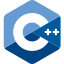
<br>

<div style="text-align:center; font-size:200%;">
 <b>Das Statische Strategie Pattern</b>
</div>
<br/>
<div style="text-align:center; font-size:120%;">Dr. Matthias Hölzl</div>
<br/>
<div style="text-align:center;">Coding-Akademie München</div>
<br/>
<!-- 07 Das Statische Strategie Pattern.ipynb -->
<!-- slides/module_470_cpp_patterns/topic_200_static_strategy.cpp -->


### Zweck des Strategy Patterns

- Austauschbare Algorithmen / austauschbares Verhalten
- Algorithmen unabhängig von Klassen, die sie verwenden


### Motivation für das Strategy Pattern

- Textumbruch [...]


## Struktur des Strategy Patterns

<img src="img/pat_strategy.svg"
     style="display:block;margin:auto;width:80%"/>

In [ ]:
#include <iostream>
#include <xcpp/xdisplay.hpp>

In [ ]:
class ContextDataInterface {
public:
    ContextDataInterface() = default;
    ContextDataInterface(const ContextDataInterface&) = delete;
    ContextDataInterface& operator=(const ContextDataInterface&) = delete;
    ContextDataInterface(ContextDataInterface&&) = delete;
    ContextDataInterface& operator=(ContextDataInterface&&) = delete;
    virtual ~ContextDataInterface() = default;

    virtual int GetDataForAlgorithm() const = 0;
};

In [ ]:
class Strategy {
public:
    Strategy() = default;
    virtual ~Strategy() = default;
    Strategy(const Strategy&) = delete;
    Strategy& operator=(const Strategy&) = delete;
    Strategy(Strategy&&) = delete;
    Strategy& operator=(Strategy&&) = delete;

    virtual float AlgorithmInterface(const ContextDataInterface& context) = 0;
};


- Wir definieren keine explizite Schnittstelle für das statische Strategy Pattern
(bis C++17)
- In C++20 können wir Concepts verwenden
- Ein "statisches Interface" würde folgendermaßen aussehen:

In [ ]:
#include <memory>

In [ ]:
class Context : public ContextDataInterface {
public:
    Context(std::unique_ptr<Strategy> strategy) : strategy_(std::move(strategy)) {}

    float ContextInterface() { return strategy_->AlgorithmInterface(*this); }

    void SetStrategy(std::unique_ptr<Strategy> strategy) {
        strategy_ = std::move(strategy);
    }

    int GetDataForAlgorithm() const override { return myDataForAlgorithm_; }

private:
    std::unique_ptr<Strategy> strategy_;
    int myDataForAlgorithm_{42};
};

In [ ]:
template <typename ConcreteStrategy>
class StaticContext {
public:
    float ContextInterface() {
        static ConcreteStrategy strategy;
        return strategy.AlgorithmInterface(*this);
    }

    int GetDataForAlgorithm() const { return myDataForAlgorithm_; }

private:
    int myDataForAlgorithm_{42};
};

In [ ]:
class ConcreteStrategyA : public Strategy {
public:
    float AlgorithmInterface(const ContextDataInterface& context) override {
        auto data = context.GetDataForAlgorithm();
        return data + 1.5;
    }
};

In [ ]:
class ConcreteStrategyB : public Strategy {
public:
    float AlgorithmInterface(const ContextDataInterface& context) override {
        auto data = context.GetDataForAlgorithm();
        return data / 2.0;
    }
};

In [ ]:
class ConcreteStaticStrategyA {
public:
    float AlgorithmInterface(const StaticContext<ConcreteStaticStrategyA>& context) {
        auto data = context.GetDataForAlgorithm();
        return data + 1.5;
    }
};

In [ ]:
class ConcreteStaticStrategyB {
public:
    float AlgorithmInterface(const StaticContext<ConcreteStaticStrategyB>& context) {
        auto data = context.GetDataForAlgorithm();
        return data / 2.0;
    }
};

In [ ]:
Context context{std::make_unique<ConcreteStrategyA>()};
std::cout << "Strategy A: " << context.ContextInterface() << "\n";
context.SetStrategy(std::make_unique<ConcreteStrategyB>());
std::cout << "Strategy B: " << context.ContextInterface() << "\n";

In [ ]:
StaticContext<ConcreteStaticStrategyA> staticContextA;
std::cout << "Static Strategy A: " << staticContextA.ContextInterface() << "\n";

In [ ]:
StaticContext<ConcreteStaticStrategyB> staticContextB;
std::cout << "Static Strategy B: " << staticContextB.ContextInterface() << "\n";


## Beispiel: Textumbruch

In [ ]:
// We don't need a superclass. The interface would be something like this:
//
// class TextWrapStrategy {
// public:
//     std::vector<std::string> Wrap(const std::string& text, int width);
// };

In [ ]:
class TruncationStrategy {
public:
    // No override keyword here, because we don't inherit from a superclass
    std::vector<std::string> Wrap(const std::string& text, int width) {
        if (text.size() <= width) {
            return {text};
        }
        return {text.substr(0, width - 3) + "..."};
    }
};

In [ ]:
class BreakAnywhereStrategy {
public:
    std::vector<std::string> Wrap(const std::string& text, int width) {
        std::string remainingText{text};
        std::vector<std::string> lines;
        while (remainingText.size() > width) {
            lines.push_back(remainingText.substr(0, width));
            remainingText = remainingText.substr(width);
        }
        lines.push_back(remainingText);
        return lines;
    }
};

In [ ]:
class BreakOnSpaceStrategy {
public:
    std::vector<std::string> Wrap(const std::string& text, int width) {
        std::vector<std::string> lines;
        std::string remainingText{text};
        while (remainingText.size() > width) {
            auto pos = remainingText.find_last_of(' ', width);
            if (pos == std::string::npos) {
                pos = width;
            }
            lines.push_back(remainingText.substr(0, pos));
            remainingText = remainingText.substr(pos + 1);
        }
        lines.push_back(remainingText);
        return lines;
    }
};

In [ ]:
class BlogPost {
public:
    BlogPost(
        const std::string& author, const std::string& title, const std::string& text)
        : author_{author}, title_{title}, text_{text} {}

    const std::string& GetAuthor() const { return author_; }
    const std::string& GetTitle() const { return title_; }
    const std::string& GetText() const { return text_; }

private:
    std::string author_;
    std::string title_;
    std::string text_;
};

In [ ]:
template <typename TextWrapStrategy>
class Blog {
public:
    void Print(int width) {
        static TextWrapStrategy strategy;
        for (const auto& post : posts_) {
            std::cout << std::string(width, '-') << "\n";
            std::cout << "Title: " << post.GetTitle() << "\n";
            std::cout << "Author: " << post.GetAuthor() << "\n";
            for (const auto& line : strategy.Wrap(post.GetText(), width)) {
                std::cout << line << "\n";
            }
            std::cout << std::string(width, '-') << "\n";
        }
    }

    void AddPost(const BlogPost& post) { posts_.push_back(post); }

private:
    std::vector<BlogPost> posts_;
};

In [ ]:
std::string firstPost{"This is my first post. This is my first post. This is my first "
                      "post. This is my first post. This is my first post. This is my "
                      "first post. This is my first post. This is my first post. "};
std::string secondPost {
    "This is my second post. This is my second post. This is my second post. This is "
    "my second post. This is my second post. This is my second post. This is my second "
    "post. This is my second post. This is my second post. This is my second post. "
    "This is my second post. This is my second post. "
}

In [ ]:
template <typename TruncationStrategy>
Blog<TruncationStrategy> MakeBlog() {
    Blog<TruncationStrategy> blog;

    blog.AddPost({"John Doe", "My first post", firstPost});
    blog.AddPost({"Jane Doe", "My second post", secondPost});
    return blog;
}

In [ ]:
auto blog{MakeBlog<TruncationStrategy>()};

In [ ]:
blog.Print(40);

In [ ]:
auto blog{MakeBlog<BreakAnywhereStrategy>()};

In [ ]:
blog.Print(40);

In [ ]:
auto blog{MakeBlog<BreakOnSpaceStrategy>()};

In [ ]:
blog.Print(40);


### Implementierung mit Funktions-Objekt (1)

In [ ]:
template <std::vector<std::string> textWrapStrategy(const std::string& text, int width)>
class FunBlog {
public:
    void Print(int width) {

        for (const auto& post : posts_) {
            std::cout << std::string(width, '-') << "\n";
            std::cout << "Title: " << post.GetTitle() << "\n";
            std::cout << "Author: " << post.GetAuthor() << "\n";
            for (const auto& line : textWrapStrategy(post.GetText(), width)) {
                std::cout << line << "\n";
            }
            std::cout << std::string(width, '-') << "\n";
        }
    }

    void AddPost(const BlogPost& post) { posts_.push_back(post); }

private:
    std::vector<BlogPost> posts_;
};

In [ ]:
std::vector<std::string> TruncateLines(const std::string& text, int width) {
    if (text.size() <= width) {
        return {text};
    }
    return {text.substr(0, width - 3) + "..."};
}

In [ ]:
template <std::vector<std::string> textWrapStrategy(const std::string& text, int width)>
FunBlog<textWrapStrategy> MakeFunBlog() {
    FunBlog<textWrapStrategy> blog;

    blog.AddPost({"John Doe", "My first post", firstPost});
    blog.AddPost({"Jane Doe", "My second post", secondPost});
    return blog;
}

In [ ]:
auto blog{MakeFunBlog<TruncateLines>()};

In [ ]:
blog.Print(40);

In [ ]:
class FunTruncateLinesStrategy {
public:
    std::vector<std::string> operator()(const std::string& text, int width) {
        if (text.size() <= width) {
            return {text};
        }
        return {text.substr(0, width - 3) + "..."};
    }
};

In [ ]:
FunTruncateLinesStrategy funStrategy{};

In [ ]:
xcpp::display(funStrategy(firstPost, 40));

In [ ]:
// auto blog{MakeFunBlog<funStrategy>};


### Implementierung mit Funktions-Objekt (2)

In [ ]:
template <typename TextWrapStrategy>
class FunBlog {
public:
    void Print(int width) {
        TextWrapStrategy strategy;
        for (const auto& post : posts_) {
            std::cout << std::string(width, '-') << "\n";
            std::cout << "Title: " << post.GetTitle() << "\n";
            std::cout << "Author: " << post.GetAuthor() << "\n";
            for (const auto& line : strategy(post.GetText(), width)) {
                std::cout << line << "\n";
            }
            std::cout << std::string(width, '-') << "\n";
        }
    }

    void AddPost(const BlogPost& post) { posts_.push_back(post); }

private:
    std::vector<BlogPost> posts_;
};

In [ ]:
template <typename TextWrapStrategy>
FunBlog<TextWrapStrategy> MakeFunBlog() {
    FunBlog<TextWrapStrategy> blog;

    blog.AddPost({"John Doe", "My first post", firstPost});
    blog.AddPost({"Jane Doe", "My second post", secondPost});
    return blog;
}

In [ ]:
auto blog{MakeFunBlog<FunTruncateLinesStrategy>()};

In [ ]:
blog.Print(40);